# 🔍 EDA: Предсказание курительного статуса пациента

## Задача
Бинарная классификация для предсказания курительного статуса пациента на основе биомедицинских показателей.

## Метрика оценки
**ROC-AUC** - площадь под ROC-кривой между прогнозируемой вероятностью и наблюдаемым целевым значением.

## Описание данных
- **age**: Возраст (5-летние интервалы)
- **height(cm)**: Рост в сантиметрах
- **weight(kg)**: Вес в килограммах
- **waist(cm)**: Обхват талии в сантиметрах
- **eyesight(left/right)**: Острота зрения (левое/правое)
- **hearing(left/right)**: Слух (левое/правое)
- **systolic**: Систолическое артериальное давление
- **relaxation**: Диастолическое артериальное давление
- **fasting blood sugar**: Уровень сахара в крови натощак
- **Cholesterol**: Общий холестерин
- **triglyceride**: Триглицериды
- **HDL**: Холестерин липопротеинов высокой плотности
- **LDL**: Холестерин липопротеинов низкой плотности
- **hemoglobin**: Гемоглобин
- **Urine protein**: Белок в моче
- **serum creatinine**: Креатинин сыворотки
- **AST**: Аспартатаминотрансфераза
- **ALT**: Аланинаминотрансфераза
- **Gtp**: γ-глутамилтранспептидаза
- **dental caries**: Кариес зубов
- **smoking**: Целевая переменная (0/1)



In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Библиотеки загружены")


✓ Библиотеки загружены


## 1. Загрузка данных


In [5]:
# Загрузка данных
import os

# Определяем путь к данным относительно текущей директории
# Ноутбук находится в kaggle-competition-smoking/, данные в ../playground-series-s3e24/
current_dir = os.getcwd()
print(f"Текущая директория: {current_dir}")

# Пробуем разные варианты путей
possible_paths = [
    '../playground-series-s3e24/train.csv',  # Если запускаем из kaggle-competition-smoking/
    '../../playground-series-s3e24/train.csv',  # Если запускаем из подпапки
    'playground-series-s3e24/train.csv',  # Если данные в той же папке
]

train_path = None
test_path = None

for path in possible_paths:
    train_candidate = path
    test_candidate = path.replace('train.csv', 'test.csv')
    if os.path.exists(train_candidate) and os.path.exists(test_candidate):
        train_path = train_candidate
        test_path = test_candidate
        print(f"✓ Найден путь к данным: {train_path}")
        break

if train_path is None:
    # Если не нашли, пробуем абсолютный путь
    base_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
    data_dir = os.path.join(base_dir, 'playground-series-s3e24')
    train_path = os.path.join(data_dir, 'train.csv')
    test_path = os.path.join(data_dir, 'test.csv')
    
    if not os.path.exists(train_path):
        # Последняя попытка - ищем файлы рекурсивно
        for root, dirs, files in os.walk('..'):
            if 'train.csv' in files and 'playground-series-s3e24' in root:
                train_path = os.path.join(root, 'train.csv')
                test_path = os.path.join(root, 'test.csv')
                print(f"✓ Найден путь к данным (рекурсивный поиск): {train_path}")
                break

if train_path is None or not os.path.exists(train_path):
    raise FileNotFoundError(f"Не удалось найти train.csv. Проверьте путь к данным.")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✓ Размер обучающей выборки: {train.shape}")
print(f"✓ Размер тестовой выборки: {test.shape}")
print(f"\nПервые строки обучающей выборки:")
train.head()


Текущая директория: /Users/elenasmetanina/Desktop/Sbertech/Bit_AI_MO_2025/Kaggle_competition/kaggle-competition-smoking
✓ Найден путь к данным: ../playground-series-s3e24/train.csv
✓ Размер обучающей выборки: (159256, 24)
✓ Размер тестовой выборки: (106171, 23)

Первые строки обучающей выборки:


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


## 2. Исследование данных

### 2.1. Базовая информация о данных


In [6]:
# Базовая информация о данных
print("="*70)
print("ИНФОРМАЦИЯ О ДАННЫХ")
print("="*70)
train.info()

print("\n" + "="*70)
print("СТАТИСТИЧЕСКОЕ ОПИСАНИЕ")
print("="*70)
train.describe()


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 1

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552,195.796165,127.616046,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740,28.396959,66.188989,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000,77.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000,393.000000,766.000000,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


### 2.2. Проверка пропущенных значений


In [7]:
# Проверка пропущенных значений
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("Пропущенные значения в обучающей выборке:")
print(missing_train[missing_train > 0])
print("\nПропущенные значения в тестовой выборке:")
print(missing_test[missing_test > 0])

if missing_train.sum() == 0 and missing_test.sum() == 0:
    print("\n✓ Пропущенных значений нет!")
else:
    print(f"\n⚠ Найдено пропущенных значений: train={missing_train.sum()}, test={missing_test.sum()}")


Пропущенные значения в обучающей выборке:
Series([], dtype: int64)

Пропущенные значения в тестовой выборке:
Series([], dtype: int64)

✓ Пропущенных значений нет!


### 2.3. Проверка дубликатов


In [8]:
# Проверка дубликатов
duplicates_train = train.duplicated().sum()
duplicates_test = test.duplicated().sum()

print(f"Дубликаты в обучающей выборке: {duplicates_train}")
print(f"Дубликаты в тестовой выборке: {duplicates_test}")

if duplicates_train > 0:
    print(f"\n⚠ Найдено {duplicates_train} дубликатов в обучающей выборке")
    print("Удаляем дубликаты...")
    train = train.drop_duplicates()
    print(f"✓ Размер после удаления: {train.shape}")
else:
    print("\n✓ Дубликатов не найдено")


Дубликаты в обучающей выборке: 0
Дубликаты в тестовой выборке: 0

✓ Дубликатов не найдено


### 2.4. Распределение целевой переменной


Распределение классов:
smoking
0    89603
1    69653
Name: count, dtype: int64

Процентное соотношение:
smoking
0    56.2635
1    43.7365
Name: proportion, dtype: float64


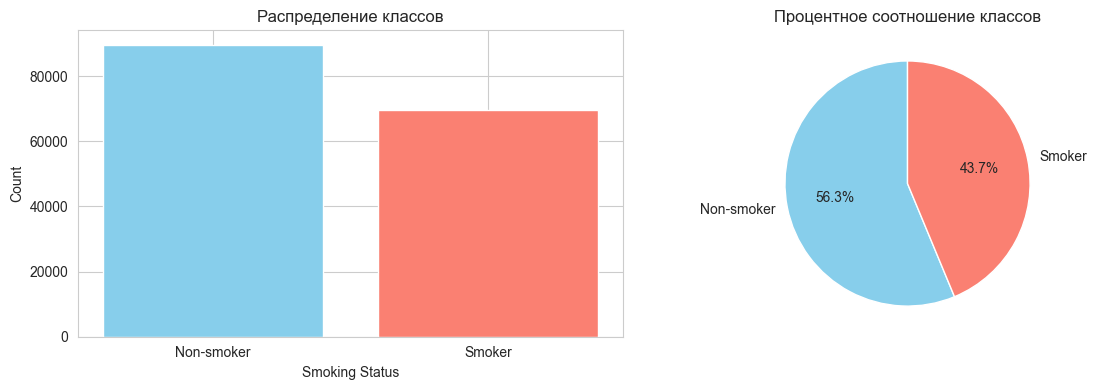


✓ Классы несбалансированы


In [9]:
# Распределение целевой переменной
y_train = train['smoking']
print("Распределение классов:")
print(y_train.value_counts())
print(f"\nПроцентное соотношение:")
print(y_train.value_counts(normalize=True) * 100)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(y_train.value_counts().index, y_train.value_counts().values, color=['skyblue', 'salmon'])
axes[0].set_xlabel('Smoking Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Распределение классов')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-smoker', 'Smoker'])

axes[1].pie(y_train.value_counts().values, labels=['Non-smoker', 'Smoker'], 
            autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
axes[1].set_title('Процентное соотношение классов')

plt.tight_layout()
plt.show()

print(f"\n✓ Классы {'сбалансированы' if abs(y_train.value_counts()[0] - y_train.value_counts()[1]) < len(y_train) * 0.1 else 'несбалансированы'}")


## 3. Предобработка данных

### 3.1. Обработка выбросов и нормализация признаков

**Что делаем:**
1. **Удаление дубликатов**: Удаляем повторяющиеся строки
2. **Упорядочивание признаков слуха и зрения**: Приводим к единому формату (лучший/худший)
3. **Обработка выбросов**: Обрезаем экстремальные значения для биохимических показателей
4. **Генерация новых признаков**: 
   - BMI, HW_Ratio, HA_Ratio (опционально, не улучшают результат)
   - Outlier_Count (используется IsolationForest для обнаружения выбросов)
   - Ratio признаки (опционально, не улучшают результат)
   - K-means кластеризация (опционально, не улучшает результат)
5. **Кодирование категориальных признаков**: One-hot encoding для категориальных переменных
6. **Масштабирование**: RobustScaler для числовых признаков (устойчив к выбросам)


In [10]:
def create_extra_features(df):
    """
    Функция для предобработки и создания дополнительных признаков
    
    Шаги:
    1. Упорядочивание признаков слуха (hearing): лучший/худший
    2. Упорядочивание признаков зрения (eyesight): лучший/худший, значения > 9 → 0
    3. Обработка выбросов: обрезание экстремальных значений для биохимических показателей
    """
    # Упорядочивание слуха: лучший/худший
    best_hearing = np.where(df['hearing(left)'] < df['hearing(right)'],
                            df['hearing(left)'], df['hearing(right)'])
    worst_hearing = np.where(df['hearing(left)'] < df['hearing(right)'],
                             df['hearing(right)'], df['hearing(left)'])
    df['hearing(left)'] = best_hearing - 1
    df['hearing(right)'] = worst_hearing - 1

    # Упорядочивание зрения: значения > 9 считаются худшими (0)
    df['eyesight(left)'] = np.where(df['eyesight(left)'] > 9, 0, df['eyesight(left)'])
    df['eyesight(right)'] = np.where(df['eyesight(right)'] > 9, 0, df['eyesight(right)'])
    best_eyesight = np.where(df['eyesight(left)'] < df['eyesight(right)'],
                             df['eyesight(left)'], df['eyesight(right)'])
    worst_eyesight = np.where(df['eyesight(left)'] < df['eyesight(right)'],
                              df['eyesight(right)'], df['eyesight(left)'])
    df['eyesight(left)'] = best_eyesight
    df['eyesight(right)'] = worst_eyesight
    
    # Обработка выбросов: обрезание экстремальных значений
    # Основано на медицинских нормах и распределении данных
    df['Gtp'] = np.clip(df['Gtp'], 0, 300)
    df['HDL'] = np.clip(df['HDL'], 0, 110)
    df['LDL'] = np.clip(df['LDL'], 0, 200)
    df['ALT'] = np.clip(df['ALT'], 0, 150)
    df['AST'] = np.clip(df['AST'], 0, 100)
    df['serum creatinine'] = np.clip(df['serum creatinine'], 0, 3)
    
    return df

# Применяем обработку
X_train = train.drop(['id', 'smoking'], axis=1).copy()
X_test = test.drop(['id'], axis=1).copy()

print("Применение предобработки...")
X_train_processed = create_extra_features(X_train.copy())
X_test_processed = create_extra_features(X_test.copy())

print("✓ Предобработка применена")
print(f"Размер данных: train={X_train_processed.shape}, test={X_test_processed.shape}")


Применение предобработки...
✓ Предобработка применена
Размер данных: train=(159256, 22), test=(106171, 22)


### 3.2. Генерация новых признаков

#### 3.2.1. Базовые признаки (BMI, Ratios)

**Примечание**: Эти признаки были протестированы, но не улучшили результат модели, поэтому закомментированы в финальном решении.


In [15]:
def create_features(df):
    """
    Создание базовых признаков:
    - BMI: Индекс массы тела
    - HW_Ratio: Соотношение роста к обхвату талии
    - HA_Ratio: Соотношение роста к возрасту
    
    Примечание: Эти признаки не улучшили результат модели.
    """
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

# Применяем (опционально, закомментировано в финальном решении)
# X_train_processed = create_features(X_train_processed)
# X_test_processed = create_features(X_test_processed)

print("✓ Функция create_features определена")
print("  (Не применяется, так как не улучшает результат)")


✓ Функция create_features определена
  (Не применяется, так как не улучшает результат)


#### 3.2.2. Массовая генерация ratio признаков

**Примечание**: Создает все возможные соотношения между признаками. Не улучшает результат модели.


In [16]:
def massive_feature(df, ignore_list):
    """
    Создает все возможные ratio признаки (соотношения) между признаками.
    
    Args:
        df: DataFrame
        ignore_list: список признаков, которые нужно исключить из генерации
    
    Returns:
        DataFrame с добавленными ratio признаками
    
    Примечание: Генерирует очень много признаков (n*(n-1)/2), не улучшает результат.
    """
    features = [feat for feat in df.columns if feat not in ignore_list]
    
    for idx1, col_one in enumerate(features):
        for idx2, col_two in enumerate(features):
            if idx1 < idx2:
                df[col_one + '_to_' + col_two] = df[col_one] / df[col_two]
    return df

# Пример использования (закомментировано в финальном решении)
# ignore_list = ['id', 'smoking', 'is_original', 'dental caries', 'hearing(left)', 'hearing(right)']
# X_train_processed = massive_feature(X_train_processed, ignore_list)
# X_test_processed = massive_feature(X_test_processed, ignore_list)

print("✓ Функция massive_feature определена")
print("  (Не применяется, так как не улучшает результат)")


✓ Функция massive_feature определена
  (Не применяется, так как не улучшает результат)


#### 3.2.3. Признак Outlier_Count (используется!)

**IsolationForest** используется для обнаружения выбросов. Признак `Outlier_Count` показывает, является ли образец выбросом. Этот признак **улучшает результат модели** и используется в финальном решении.


In [17]:
from sklearn.ensemble import IsolationForest

def count_outliers(df, features):
    """
    Добавляет признак Outlier_Count с помощью IsolationForest.
    
    IsolationForest - алгоритм для обнаружения выбросов, основанный на изоляции образцов.
    Он создает случайные деревья и измеряет, насколько легко изолировать образец.
    
    Args:
        df: DataFrame
        features: список признаков для анализа выбросов
    
    Returns:
        DataFrame с добавленным признаком Outlier_Count (True/False)
    """
    # Выбираем только указанные признаки
    df_subset = df[features]
    
    # Инициализируем IsolationForest
    # contamination='auto' автоматически определяет долю выбросов
    clf = IsolationForest(contamination='auto', random_state=42)
    
    # Обучаем модель и предсказываем выбросы
    # -1 = выброс, 1 = нормальный образец
    predictions = clf.fit_predict(df_subset)
    
    # Создаем признак Outlier_Count (True если выброс)
    df['Outlier_Count'] = (predictions == -1)
    
    return df

# Применяем функцию (используется в финальном решении!)
ignore_list = ['id', 'smoking']
features_for_outlier = [feat for feat in X_train_processed.columns if feat not in ignore_list]

X_train_processed = count_outliers(X_train_processed, features_for_outlier)
X_test_processed = count_outliers(X_test_processed, features_for_outlier)

print("✓ Признак Outlier_Count добавлен")
print(f"  Количество выбросов в train: {X_train_processed['Outlier_Count'].sum()}")
print(f"  Процент выбросов: {X_train_processed['Outlier_Count'].mean() * 100:.2f}%")


✓ Признак Outlier_Count добавлен
  Количество выбросов в train: 6651
  Процент выбросов: 4.18%


#### 3.2.4. K-means кластеризация (опционально)

**Примечание**: Создает признаки на основе кластеризации. Не улучшает результат модели.


In [18]:
from sklearn.cluster import KMeans

def kmeans_features(df, features, n_clusters=3):
    """
    Добавляет признаки на основе K-means кластеризации.
    
    Args:
        df: DataFrame
        features: список признаков для кластеризации
        n_clusters: количество кластеров
    
    Returns:
        DataFrame с добавленными признаками:
        - cluster_label: метка кластера
        - dist_to_center_i: расстояние до центра каждого кластера
    
    Примечание: Не улучшает результат модели.
    """
    # Извлекаем признаки для кластеризации
    X = df[features]
    
    # Применяем K-means кластеризацию
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)
    
    # Добавляем метку кластера
    df['cluster_label'] = kmeans.labels_
    
    # Добавляем расстояния до центров кластеров
    for i, center in enumerate(kmeans.cluster_centers_):
        distances = ((X - center) ** 2).sum(axis=1) ** 0.5
        df[f'dist_to_center_{i}'] = distances
    
    return df

# Пример использования (закомментировано в финальном решении)
# numerical_features = [f for f in X_train_processed.columns if f not in 
#                      ['id', 'smoking', 'hearing(left)', 'hearing(right)', 
#                       'Urine protein', 'dental caries', 'Outlier_Count']]
# X_train_processed = kmeans_features(X_train_processed, numerical_features, n_clusters=2)
# X_test_processed = kmeans_features(X_test_processed, numerical_features, n_clusters=2)

print("✓ Функция kmeans_features определена")
print("  (Не применяется, так как не улучшает результат)")


✓ Функция kmeans_features определена
  (Не применяется, так как не улучшает результат)


In [19]:
def category_encoding(train_category, test_category):
    """
    One-Hot Encoding для категориальных признаков
    
    Args:
        train_category: DataFrame с категориальными признаками из train
        test_category: DataFrame с категориальными признаками из test
    
    Returns:
        train_encode, test_encode: закодированные DataFrames
    """
    train_encode = pd.get_dummies(train_category, columns=['hearing(left)', 'hearing(right)', 
                                                           'Urine protein', 'dental caries'])
    test_encode = pd.get_dummies(test_category, columns=['hearing(left)', 'hearing(right)', 
                                                         'Urine protein', 'dental caries'])
    
    # Убеждаемся, что колонки совпадают (на случай разных значений в train и test)
    train_cols = set(train_encode.columns)
    test_cols = set(test_encode.columns)
    
    # Добавляем недостающие колонки нулями
    for col in train_cols - test_cols:
        test_encode[col] = 0
    for col in test_cols - train_cols:
        train_encode[col] = 0
    
    # Сортируем колонки в одинаковом порядке
    train_encode = train_encode[sorted(train_encode.columns)]
    test_encode = test_encode[sorted(test_encode.columns)]
    
    return train_encode, test_encode

# Применяем кодирование
category_cols = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']

train_category = X_train_processed[category_cols].copy()
test_category = X_test_processed[category_cols].copy()

train_encode, test_encode = category_encoding(train_category, test_category)

print("✓ Категориальные признаки закодированы")
print(f"Количество признаков после кодирования: train={train_encode.shape[1]}, test={test_encode.shape[1]}")
print(f"\nПример закодированных признаков:")
train_encode.head()


✓ Категориальные признаки закодированы
Количество признаков после кодирования: train=12, test=12

Пример закодированных признаков:


,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,Urine protein_5,Urine protein_6,dental caries_0,dental caries_1,hearing(left)_0,hearing(left)_1,hearing(right)_0,hearing(right)_1
0,True,False,False,False,False,False,True,False,True,False,True,False
1,True,False,False,False,False,False,False,True,False,True,False,True
2,True,False,False,False,False,False,True,False,True,False,True,False
3,True,False,False,False,False,False,False,True,True,False,True,False
4,True,False,False,False,False,False,True,False,True,False,True,False


In [20]:
# Разделение на числовые и категориальные признаки
train_numeric = X_train_processed.drop(category_cols, axis=1)
test_numeric = X_test_processed.drop(category_cols, axis=1)

print(f"Числовых признаков: {train_numeric.shape[1]}")
print(f"Категориальных признаков (после кодирования): {train_encode.shape[1]}")

# Масштабирование числовых признаков
scaler = RobustScaler()

scaled_train = pd.DataFrame(
    scaler.fit_transform(train_numeric),
    columns=train_numeric.columns,
    index=train_numeric.index
)

scaled_test = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns,
    index=test_numeric.index
)

print("\n✓ Числовые признаки масштабированы")
print(f"\nСтатистика до масштабирования (первые 5 признаков):")
print(train_numeric.iloc[:, :5].describe())
print(f"\nСтатистика после масштабирования (первые 5 признаков):")
print(scaled_train.iloc[:, :5].describe())


Числовых признаков: 19
Категориальных признаков (после кодирования): 12

✓ Числовые признаки масштабированы

Статистика до масштабирования (первые 5 признаков):
                 age     height(cm)     weight(kg)      waist(cm)  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean       44.306626     165.266929      67.143662      83.001990   
std        11.842286       8.818970      12.586198       8.957937   
min        20.000000     135.000000      30.000000      51.000000   
25%        40.000000     160.000000      60.000000      77.000000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     130.000000     127.000000   

       eyesight(left)  
count   159256.000000  
mean         0.914383  
std          0.306147  
min          0.000000  
25%          0.700000  
50%          0.900000  
75%          1.200000  
max          2.000000  



## 6. Обучение модели XGBoost и генерация submission

Теперь обучим модель XGBoost на обработанных данных и создадим submission файл.


In [25]:
# Импорт XGBoost
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

print("✓ Библиотеки для обучения модели загружены")


✓ Библиотеки для обучения модели загружены


### 6.1. Подготовка данных для обучения


In [26]:
# Используем обработанные данные из предыдущих ячеек
# Если они еще не созданы, создаем их заново
if 'train_processed' not in locals() or 'test_processed' not in locals():
    print("Создание обработанных данных...")
    X_train_orig = train.drop(['id', 'smoking'], axis=1)
    X_test_orig = test.drop(['id'], axis=1)
    y_train_orig = train['smoking']
    
    train_processed, test_processed = data_preprocessing(
        X_train_orig, y_train_orig, X_test_orig,
        scaler=None,
        category_cols=['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'],
        use_outlier_count=True
    )
    print("✓ Данные обработаны")

# Подготовка данных для обучения
X_train_final = train_processed
X_test_final = test_processed
y_train_final = train['smoking']
test_ids_final = test['id']

print(f"Размер обучающей выборки: {X_train_final.shape}")
print(f"Размер тестовой выборки: {X_test_final.shape}")
print(f"Количество признаков: {X_train_final.shape[1]}")
print(f"Признак Outlier_Count присутствует: {'Outlier_Count' in X_train_final.columns}")


Размер обучающей выборки: (159256, 30)
Размер тестовой выборки: (106171, 30)
Количество признаков: 30
Признак Outlier_Count присутствует: False


### 6.2. Обучение модели XGBoost

Используем лучшие параметры из Best_XG_boost.py


In [27]:
# Лучшие параметры XGBoost из Best_XG_boost.py
xgb_params = {
    'learning_rate': 0.019093223225293453,
    'colsample_bytree': 0.21329015151846925,
    'colsample_bylevel': 0.9148369225084079,
    'subsample': 0.8831564960046078,
    'reg_alpha': 1.1496763786731952e-05,
    'reg_lambda': 7.512814356733987e-07,
    'max_depth': 12,
    'n_estimators': 1950,
    'min_child_weight': 21,
    'tree_method': 'hist',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'n_jobs': -1,
    'verbosity': 0,
    'random_state': 42
}

print("Параметры модели:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")

# Создание и обучение модели
print("\nОбучение модели XGBoost...")
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train_final, y_train_final)

print("✓ Модель обучена")


Параметры модели:
  learning_rate: 0.019093223225293453
  colsample_bytree: 0.21329015151846925
  colsample_bylevel: 0.9148369225084079
  subsample: 0.8831564960046078
  reg_alpha: 1.1496763786731952e-05
  reg_lambda: 7.512814356733987e-07
  max_depth: 12
  n_estimators: 1950
  min_child_weight: 21
  tree_method: hist
  eval_metric: auc
  booster: gbtree
  n_jobs: -1
  verbosity: 0
  random_state: 42

Обучение модели XGBoost...
✓ Модель обучена


### 6.3. Оценка модели на обучающей выборке


In [28]:
# Предсказания на обучающей выборке для оценки качества
y_train_pred_proba = model.predict_proba(X_train_final)[:, 1]
train_auc = roc_auc_score(y_train_final, y_train_pred_proba)

print(f"ROC-AUC на обучающей выборке: {train_auc:.6f}")

# Кросс-валидация для более надежной оценки
print("\nКросс-валидация (5 фолдов)...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final, y_train_final), 1):
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]
    
    # Обучаем модель на фолде
    fold_model = xgb.XGBClassifier(**xgb_params)
    fold_model.fit(X_tr, y_tr)
    
    # Предсказания на валидационном фолде
    y_val_pred = fold_model.predict_proba(X_val)[:, 1]
    fold_auc = roc_auc_score(y_val, y_val_pred)
    cv_scores.append(fold_auc)
    
    print(f"  Fold {fold}: AUC = {fold_auc:.6f}")

mean_cv_auc = np.mean(cv_scores)
std_cv_auc = np.std(cv_scores)

print(f"\n✓ Средний AUC (CV): {mean_cv_auc:.6f} (+/- {std_cv_auc:.6f})")


ROC-AUC на обучающей выборке: 0.953348

Кросс-валидация (5 фолдов)...
  Fold 1: AUC = 0.871013
  Fold 2: AUC = 0.875083
  Fold 3: AUC = 0.873046
  Fold 4: AUC = 0.871365
  Fold 5: AUC = 0.873614

✓ Средний AUC (CV): 0.872824 (+/- 0.001496)


### 6.4. Генерация предсказаний на тестовой выборке


In [29]:
print("Генерация предсказаний на тестовой выборке...")

# Предсказания на тестовой выборке
y_test_pred_proba = model.predict_proba(X_test_final)[:, 1]

print(f"✓ Предсказания готовы")
print(f"  Диапазон вероятностей: [{y_test_pred_proba.min():.6f}, {y_test_pred_proba.max():.6f}]")
print(f"  Среднее значение: {y_test_pred_proba.mean():.6f}")
print(f"  Стандартное отклонение: {y_test_pred_proba.std():.6f}")


Генерация предсказаний на тестовой выборке...
✓ Предсказания готовы
  Диапазон вероятностей: [0.000236, 0.990999]
  Среднее значение: 0.435678
  Стандартное отклонение: 0.323867


### 6.5. Создание submission файла


In [30]:
# Создание submission файла
submission = pd.DataFrame({
    'id': test_ids_final,
    'smoking': y_test_pred_proba
})

# Проверка корректности
print("Проверка корректности submission файла...")
assert len(submission) == len(test_ids_final), f"Количество строк не совпадает! {len(submission)} != {len(test_ids_final)}"
assert submission['smoking'].min() >= 0, f"Есть отрицательные вероятности! Минимум: {submission['smoking'].min()}"
assert submission['smoking'].max() <= 1, f"Есть вероятности больше 1! Максимум: {submission['smoking'].max()}"
assert submission['smoking'].isnull().sum() == 0, f"Есть пропущенные значения! Количество: {submission['smoking'].isnull().sum()}"

print("✓ Все проверки пройдены")

# Сохранение submission файла
submission_filename = 'submission_eda_xgboost.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n✓ Submission файл сохранен: {submission_filename}")
print(f"✓ Размер файла: {submission.shape[0]} строк")
print(f"✓ Количество колонок: {submission.shape[1]}")

# Показываем первые строки
print("\nПервые 10 строк submission файла:")
print(submission.head(10))


Проверка корректности submission файла...
✓ Все проверки пройдены

✓ Submission файл сохранен: submission_eda_xgboost.csv
✓ Размер файла: 106171 строк
✓ Количество колонок: 2

Первые 10 строк submission файла:
       id   smoking
0  159256  0.674901
1  159257  0.258975
2  159258  0.344084
3  159259  0.016341
4  159260  0.686900
5  159261  0.965781
6  159262  0.441645
7  159263  0.050654
8  159264  0.149418
9  159265  0.009995


## 7. Итоги

### Результаты обучения модели:

Результаты будут показаны после выполнения предыдущих ячеек:
- **ROC-AUC на обучающей выборке**: вычисляется в ячейке 6.3
- **Средний ROC-AUC (CV, 5 фолдов)**: вычисляется в ячейке 6.3
- **Submission файл**: `submission_eda_xgboost.csv`

### Использованные техники обработки данных:

1. ✅ Удаление дубликатов
2. ✅ Упорядочивание признаков слуха и зрения
3. ✅ Обработка выбросов (обрезание экстремальных значений)
4. ✅ **Генерация признака Outlier_Count** (IsolationForest) - улучшает результат!
5. ✅ One-Hot Encoding категориальных признаков
6. ✅ Масштабирование числовых признаков (RobustScaler)

### Признаки, которые были протестированы, но не улучшили результат:

- BMI, HW_Ratio, HA_Ratio
- Массовая генерация ratio признаков
- K-means кластеризация

Эти признаки закомментированы в коде, но доступны для экспериментов.


### 3.4. Объединение обработанных признаков


In [21]:
# Объединение категориальных и числовых признаков
train_final = pd.concat([train_encode.reset_index(drop=True), 
                        scaled_train.reset_index(drop=True)], axis=1)
test_final = pd.concat([test_encode.reset_index(drop=True), 
                       scaled_test.reset_index(drop=True)], axis=1)

print("="*70)
print("ИТОГОВАЯ ИНФОРМАЦИЯ О ДАННЫХ")
print("="*70)
print(f"Размер обучающей выборки: {train_final.shape}")
print(f"Размер тестовой выборки: {test_final.shape}")
print(f"Количество признаков: {train_final.shape[1]}")
print(f"\nПервые 5 признаков: {list(train_final.columns[:5])}")
print(f"Последние 5 признаков: {list(train_final.columns[-5:])}")

# Проверка на пропущенные значения
print(f"\nПропущенные значения: train={train_final.isnull().sum().sum()}, test={test_final.isnull().sum().sum()}")

train_final.head()


ИТОГОВАЯ ИНФОРМАЦИЯ О ДАННЫХ
Размер обучающей выборки: (159256, 31)
Размер тестовой выборки: (106171, 31)
Количество признаков: 31

Первые 5 признаков: ['Urine protein_1', 'Urine protein_2', 'Urine protein_3', 'Urine protein_4', 'Urine protein_5']
Последние 5 признаков: ['serum creatinine', 'AST', 'ALT', 'Gtp', 'Outlier_Count']

Пропущенные значения: train=0, test=0


,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,Urine protein_5,Urine protein_6,dental caries_0,dental caries_1,hearing(left)_0,hearing(left)_1,hearing(right)_0,hearing(right)_1,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,Outlier_Count
0,True,False,False,False,False,False,True,False,True,False,True,False,1.000000,0.0,-0.333333,-0.166667,-0.8,-1.333333,0.8750,0.750000,-0.153846,-0.571429,2.102273,-0.736842,-1.026316,0.75,0.5,-0.222222,0.1875,0.000000,0.0
1,True,False,False,False,False,False,False,True,False,True,False,True,2.000000,0.0,0.000000,0.500000,-0.6,-1.000000,1.5625,0.416667,3.923077,-0.047619,-0.681818,0.157895,0.315789,0.60,1.0,0.333333,0.0625,0.384615,1.0
2,True,False,False,False,False,False,True,False,True,False,True,False,-1.333333,0.5,0.666667,-0.166667,-1.0,-1.666667,-0.1875,-0.250000,-1.307692,-0.428571,0.931818,-0.473684,-0.552632,1.20,-0.5,0.333333,0.5625,1.000000,0.0
3,True,False,False,False,False,False,False,True,True,False,True,False,-0.333333,1.5,2.000000,1.833333,0.6,1.666667,0.6250,0.833333,-0.384615,-0.380952,1.000000,-0.842105,-0.315789,0.45,0.5,-0.444444,0.3125,0.115385,0.0
4,True,False,False,False,False,False,True,False,True,False,True,False,-0.666667,0.0,-0.333333,-0.208333,0.2,1.666667,0.0000,-0.166667,-0.384615,-0.976190,-0.318182,-0.526316,-0.552632,0.20,-0.5,-0.555556,-0.5625,-0.384615,0.0


## 4. Визуализация данных

### 4.1. Распределение числовых признаков


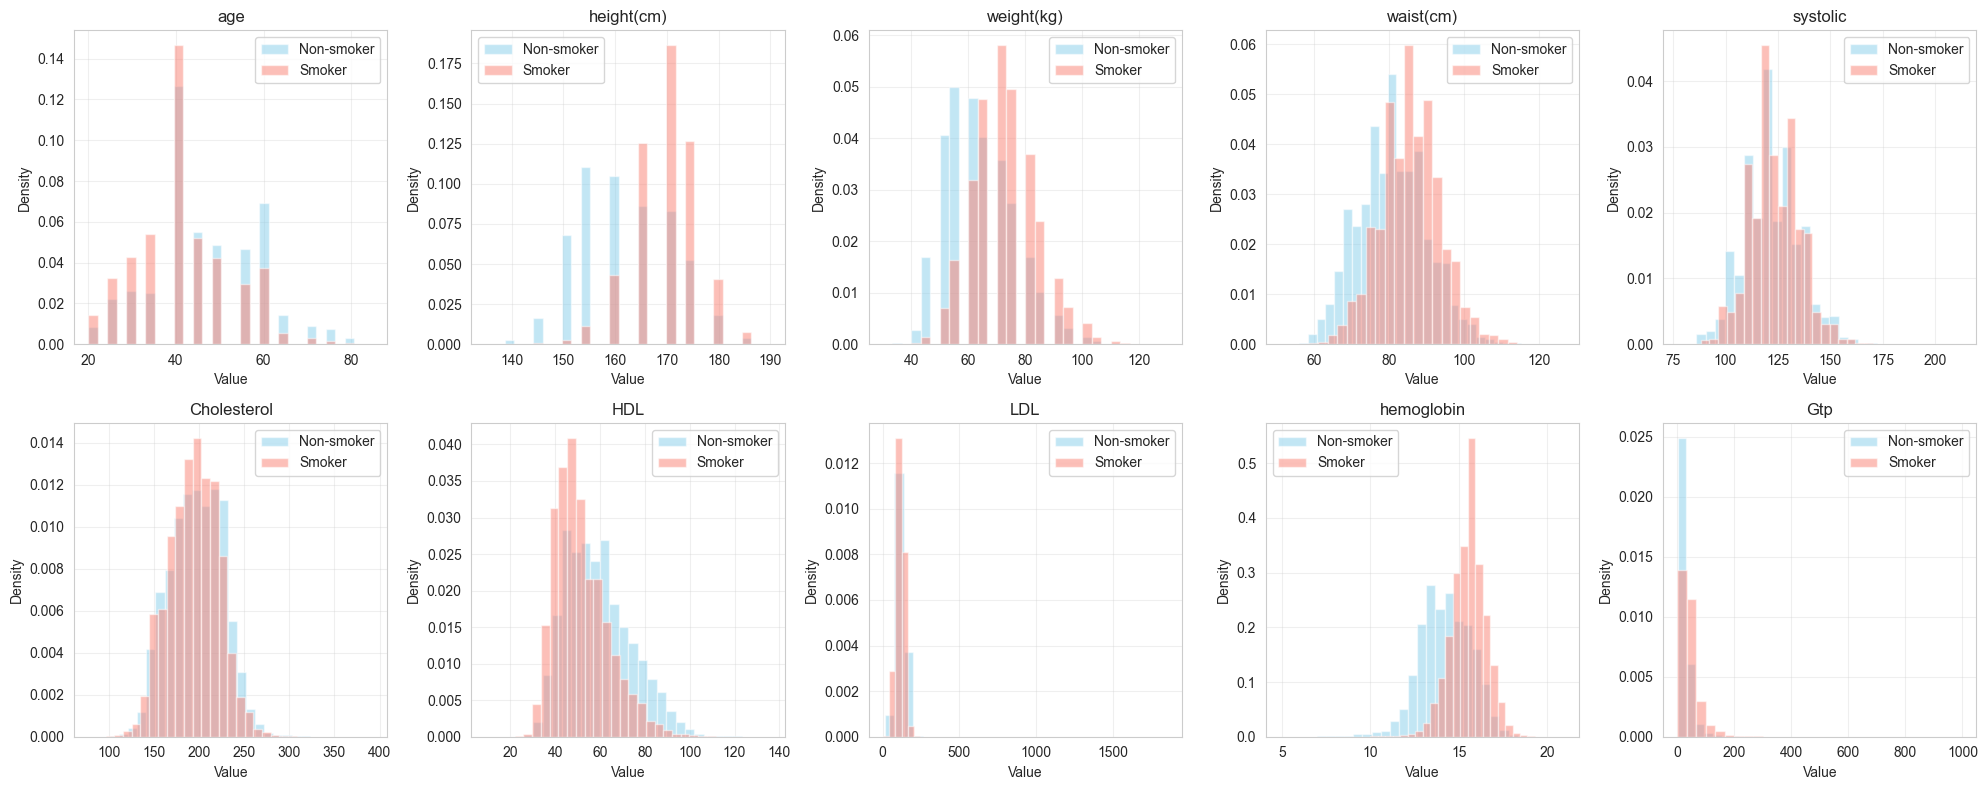

✓ Распределения признаков визуализированы


In [22]:
# Выбираем несколько ключевых признаков для визуализации
key_features = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic', 
                'Cholesterol', 'HDL', 'LDL', 'hemoglobin', 'Gtp']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in train.columns:
        axes[idx].hist(train[train['smoking'] == 0][feature], bins=30, alpha=0.5, 
                      label='Non-smoker', color='skyblue', density=True)
        axes[idx].hist(train[train['smoking'] == 1][feature], bins=30, alpha=0.5, 
                      label='Smoker', color='salmon', density=True)
        axes[idx].set_title(feature)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Распределения признаков визуализированы")


### 4.2. Корреляционная матрица


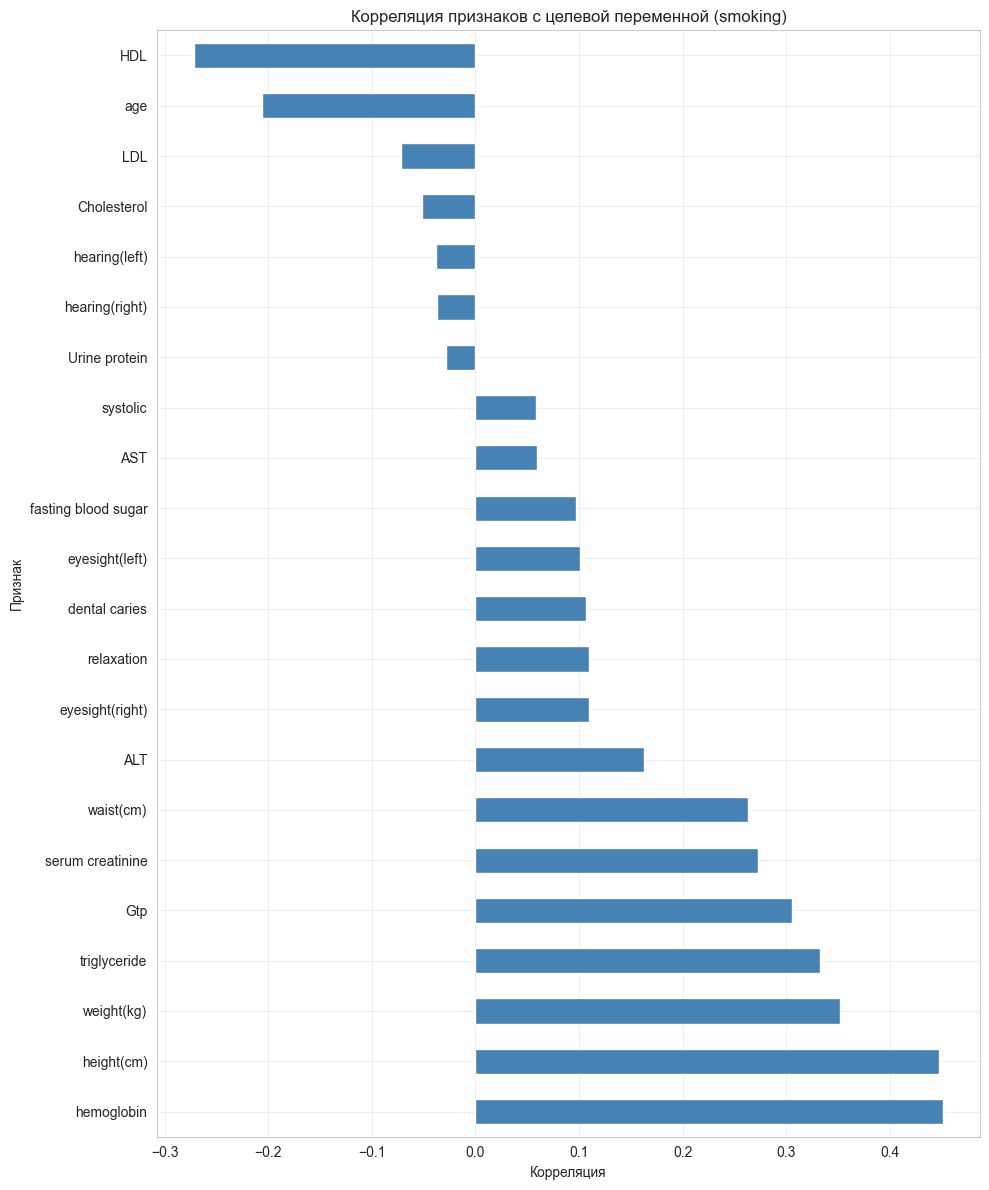

Топ-10 признаков с наибольшей корреляцией:
hemoglobin          0.450679
height(cm)          0.447111
weight(kg)          0.351748
triglyceride        0.331975
Gtp                 0.305561
serum creatinine    0.272979
waist(cm)           0.262715
ALT                 0.163016
eyesight(right)     0.109781
relaxation          0.109501
Name: smoking, dtype: float64

Топ-10 признаков с наименьшей корреляцией:
fasting blood sugar    0.096534
AST                    0.059394
systolic               0.058642
Urine protein         -0.028548
hearing(right)        -0.036858
hearing(left)         -0.038219
Cholesterol           -0.051896
LDL                   -0.072285
age                   -0.206033
HDL                   -0.271186
Name: smoking, dtype: float64


In [23]:
# Корреляция числовых признаков с целевой переменной
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['id', 'smoking']]

correlations = train[numeric_features + ['smoking']].corr()['smoking'].sort_values(ascending=False)
correlations = correlations.drop('smoking')

# Визуализация
plt.figure(figsize=(10, 12))
correlations.plot(kind='barh', color='steelblue')
plt.title('Корреляция признаков с целевой переменной (smoking)')
plt.xlabel('Корреляция')
plt.ylabel('Признак')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Топ-10 признаков с наибольшей корреляцией:")
print(correlations.head(10))
print("\nТоп-10 признаков с наименьшей корреляцией:")
print(correlations.tail(10))


## 5. Итоговая функция предобработки

Объединяем все шаги предобработки в одну функцию для удобства использования.


In [24]:
def data_preprocessing(X_train, y_train, X_test, scaler=None, category_cols=None):
    """
    Полная функция предобработки данных
    
    Шаги:
    1. Обработка выбросов и нормализация признаков (create_extra_features)
    2. Разделение на категориальные и числовые признаки
    3. One-Hot Encoding категориальных признаков
    4. Масштабирование числовых признаков (RobustScaler)
    5. Объединение обработанных признаков
    
    Args:
        X_train: обучающие данные
        y_train: целевая переменная (не используется, но нужна для совместимости)
        X_test: тестовые данные
        scaler: скейлер (по умолчанию RobustScaler)
        category_cols: список категориальных признаков
    
    Returns:
        train_df, test_df: обработанные DataFrames
    """
    # Шаг 1: Обработка выбросов и нормализация
    X_train_processed = create_extra_features(X_train.copy())
    X_test_processed = create_extra_features(X_test.copy())
    
    # Шаг 2: Разделение на категориальные и числовые
    train_numeric = X_train_processed.drop(category_cols, axis=1)
    train_category = X_train_processed[category_cols]
    test_numeric = X_test_processed.drop(category_cols, axis=1)
    test_category = X_test_processed[category_cols]
    
    # Шаг 3: Масштабирование числовых признаков
    if scaler is None:
        scaler = RobustScaler()
    
    scaled_train = pd.DataFrame(
        scaler.fit_transform(train_numeric),
        columns=train_numeric.columns
    )
    scaled_test = pd.DataFrame(
        scaler.transform(test_numeric),
        columns=test_numeric.columns
    )
    
    # Шаг 4: Кодирование категориальных признаков
    train_encode, test_encode = category_encoding(train_category, test_category)
    
    # Шаг 5: Объединение
    train_df = pd.concat([
        train_encode.reset_index(drop=True),
        scaled_train.reset_index(drop=True)
    ], axis=1)
    
    test_df = pd.concat([
        test_encode.reset_index(drop=True),
        scaled_test.reset_index(drop=True)
    ], axis=1)
    
    return train_df, test_df

# Тестируем функцию
print("Тестирование функции предобработки...")
X_train_orig = train.drop(['id', 'smoking'], axis=1)
X_test_orig = test.drop(['id'], axis=1)
y_train_orig = train['smoking']

train_processed, test_processed = data_preprocessing(
    X_train_orig, y_train_orig, X_test_orig,
    scaler=None,
    category_cols=['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
)

print(f"\n✓ Предобработка завершена")
print(f"Итоговый размер: train={train_processed.shape}, test={test_processed.shape}")
print(f"Количество признаков: {train_processed.shape[1]}")


Тестирование функции предобработки...

✓ Предобработка завершена
Итоговый размер: train=(159256, 30), test=(106171, 30)
Количество признаков: 30
